## 1D Particle in a box

As the first exercise on fenicsx, we solve the simple 1d particle in a box defined as 
\begin{gather*}
\begin{cases}
-\dfrac{\partial^2}{\partial x^2} \phi(x) = k^2\phi(x), \qquad x \in \Omega\\
\psi(x) = 0,  \qquad x \in \Gamma_D\\
\dfrac{\partial}{\partial x} \phi(x) = 0, \qquad x \in \Gamma_N
\end{cases}
\end{gather*}

where $\Omega(x) = (0,1)$, $\Gamma_D = \Gamma_N = \{x=0,x=1\}$. For simplicity, all physical constant such as $\hbar$ and mass $\mu$ are set to unity. In this case, the PDE reduces to Helmholtz equaiton. 

In [5]:
import numpy as np
import ufl
from mpi4py import MPI
from dolfinx import fem, mesh

import matplotlib as mpl
import matplotlib.pyplot as plt

In [6]:
k0 = np.pi
x_start = 0
x_end = 1
nx = 100

For $k=\pi$, there is an analytic solution which represents the ground state of the system. We shall use this function to set the boundary conditions. 
$$
\phi_0(x) = \sqrt{\frac{2}{L}}\sin(kx)
$$

In [7]:
# define the domain
domain = mesh.create_interval(MPI.COMM_WORLD, nx, [x_start, x_end])

# define the function space
V = fem.FunctionSpace(domain, ('CG', 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# problem is defined by the weak form of the pde
F = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx - k0**2 * ufl.inner(u, v) * ufl.dx

# apply dirichlet boundary conditions
uD = fem.Function(V)
uD.interpolate(lambda x: np.sqrt(2) * np.sin(k0 * x[0]))

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bcs = [fem.dirichletbc(uD, boundary_dofs)]

# neumann conditions are handled by adding the surface term to the weak form
n = ufl.FacetNormal(domain)
uN = ufl.inner(ufl.grad(uD), n)
F += - ufl.inner(uN, v) * ufl.ds

In [8]:
# Compute solution
a = ufl.lhs(F)
l = ufl.rhs(F)
problem = fem.petsc.LinearProblem(a, l, bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

The solution obtained above, i.e. `uh.x.array` is not the unique solution as the problem leaves us with a freedom to normalize the wavefunction. Obviously, to determine this constant, we integrate the wavefunction-squared in the entire domain. 

In [9]:
# normalize the solution
norm = domain.comm.allreduce(fem.assemble_scalar(fem.form(ufl.inner(uh, uh) * ufl.dx)), op=MPI.SUM)
norm = np.sqrt(norm)

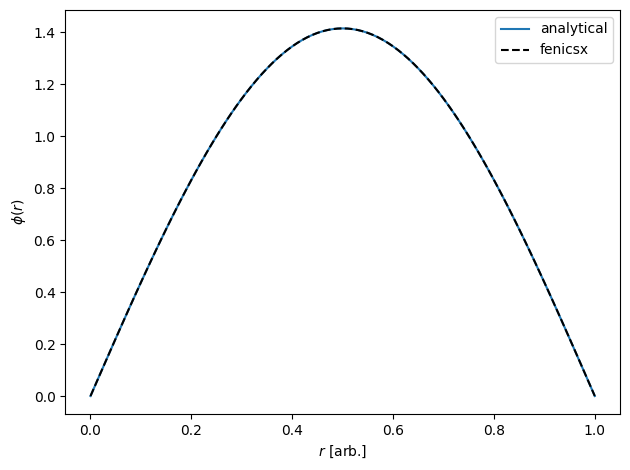

In [10]:
r = V.tabulate_dof_coordinates()[:, 0]
fig, ax = plt.subplots()
ax.plot(r, np.sqrt(2) * np.sin(k0 * r), label='analytical')
ax.plot(r, uh.x.array / norm, ls='--', c='k', label='fenicsx')
ax.set_xlabel('$r$ [arb.]')
ax.set_ylabel('$\phi(r)$')
ax.legend()
plt.tight_layout()
plt.show()